In [2]:
import os
import time
import torch
import glob
import copy

import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.dataloader import DataLoader,Dataset

from torchvision.models import resnet18
from torch.optim import Adam
from tqdm.auto import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffff'


In [3]:
train_normal = glob.glob("./Datasets/train/NORMAL/*")
train_pnuemonia = glob.glob("./Datasets/train/PNEUMONIA/*")

val_normal = glob.glob("./Datasets/val/NORMAL/*")
val_pnuemonia = glob.glob("./Datasets/val/PNEUMONIA/*")

test_normal = glob.glob("./Datasets/test/NORMAL/*")
test_pnuemonia = glob.glob("./Datasets/test/PNEUMONIA/*")



In [4]:
train_paths = train_normal + train_pnuemonia

val_paths = val_normal + val_pnuemonia

test_paths = test_normal + test_pnuemonia
# train_paths[1600]

In [5]:
train_lables = [0] * len(train_normal) + [1] * len(train_pnuemonia)

val_lables = [0] * len(val_normal) + [1] * len(val_pnuemonia)


test_lables = [0] * len(test_normal) + [1] * len(test_pnuemonia)

In [6]:
len(train_paths),len(train_lables),len(val_paths),len(val_lables),len(test_paths),len(test_lables)

(20, 20, 20, 20, 17, 17)

In [7]:
# (train_paths),(train_lables),(val_paths),(val_lables),(test_paths),(test_lables)

In [8]:
# [train_lables]
# 

In [9]:
# image = Image.open(train_paths).convert("RGB")


In [10]:
class XrayDataset(Dataset):
    def __init__(self,paths,labels,transform=None):
        self.paths=paths
        self.labels=labels
        self.transform=transform



    def __len__(self):
        return len(self.paths)
    

    def __getitem__(self, index):
        path = self.paths[index]
        image=Image.open(path).convert("RGB")

        if self.transform:
            image=self.transform(image)

        # label=self.labels[index]
        label = torch.tensor([self.labels[index]], dtype=torch.float32)

        return image,label

In [11]:
resnet18


<function torchvision.models.resnet.resnet18(*, weights: Optional[torchvision.models.resnet.ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> torchvision.models.resnet.ResNet>

In [12]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [102]:
class PneumoniaNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        self.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)

        x = x.view(x.size(0), 512)
        x = self.fc(x)

        return x
    
# not working
    # def __init__(self, weights='imagenet'):
    #     super(PneumoniaNet, self).__init__()
    #     self.backbone = resnet18(weights=weights)


In [103]:
sizeIMG = 512
train_transform = transforms.Compose([
    transforms.Resize((sizeIMG, sizeIMG)),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # transforms.ElasticTransform(),
    # transforms.,
])
test_transform = transforms.Compose([
    transforms.Resize((sizeIMG, sizeIMG)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomRotation(degrees=15),
    # transforms.ElasticTransform(),
    # transforms.,
])


train_dataset =XrayDataset(train_paths,train_lables,train_transform)
valid_dataset =XrayDataset(val_paths,val_lables,test_transform)


In [104]:
print(len(train_dataset))
print(train_dataset[0])  # Print the first example from the dataset


3266
(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  .

In [105]:
random_seed = 42
torch.manual_seed(random_seed)
print(len(train_dataset))


3266


In [106]:
batch_size = 16


In [107]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                      num_workers=0)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, num_workers=0)


In [108]:
train_dataloader


In [109]:
print(len(train_dataloader))


205


In [110]:
# for images, labels in train_dataloader:
#     print(images.shape)
#     print(labels.shape)
#     break


In [111]:
# Iterate over a few batches and print the batch index and its size
for batch_idx, (images, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx}:")
    print(images.shape)
    print(labels.shape)
    break


Batch 0:
torch.Size([16, 3, 512, 512])
torch.Size([16, 1])


In [112]:

def show_example(img, label):
    # print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    print(label)
    plt.imshow(img.permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.])


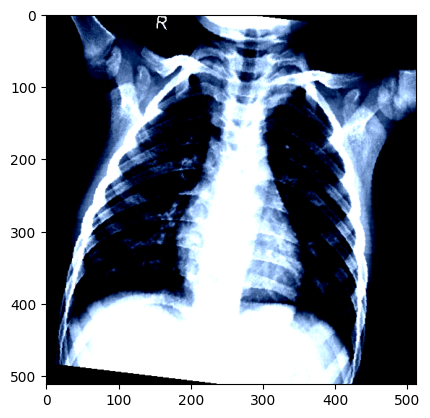

In [113]:
show_example(*train_dataset[0])


In [114]:
for images, labels in train_dataloader:
    print(images,labels)
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [115]:
from torchvision.utils import make_grid


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


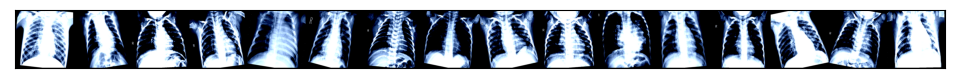

In [116]:
show_batch(train_dataloader)


In [117]:
num_epochs= 5
pretrained = True
model = PneumoniaNet(pretrained=pretrained)

# model = PneumoniaNet(weights='default')   not working
# model = PneumoniaNet(weights='imagenet') still not work
lr = 3e-3
criterion = nn.BCEWithLogitsLoss()
opt = Adam(model.parameters(), lr=lr)


c:\Users\apsag\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\apsag\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [118]:
# def __init__(self, weights="imagenet"):

# It seems that the pretrained argument in the resnet18 function has been deprecated in the torchvision library. Instead, you can use the weights argument to specify the weights you want to use for the ResNet18 model.

# To use the default pre-trained weights from the ImageNet dataset, you can set weights = 'imagenet':

# model = PneumoniaNet(weights='imagenet')
# This will initialize the ResNet18 backbone with the pre-trained weights from the ImageNet dataset.

# If you want to use the most up-to-date weights, you can use weights = 'default':

# model = PneumoniaNet(weights='default')


In [119]:
dataloaders ={
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10 if len(dataloaders["train"]) > 0 else 1,
    "val": len(dataloaders["val"]) // 10 if len(dataloaders["val"]) > 0 else 1
}
datasets_size={
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

In [120]:
def train_model(model, criterion, opt, num_epochs):
    since = time.time()
    # print(1)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in tqdm(range(num_epochs), leave=False):
        # print(2)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                # print(3)

            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                            leave=False,
                                            total=len(dataloaders[phase])):
                # print(4)

                opt.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)

                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())

                    if phase == "train":
                        loss.backward()
                        opt.step()
                running_loss += loss.item()+inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss/((i+1)*batch_size)
                    avg_acc = running_corrects/((i+1)*batch_size)

                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss : {avg_loss} | acc : {avg_acc}")

            epoch_loss = running_loss / datasets_size[phase]
            epoch_acc = running_corrects.double() / datasets_size[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(
                phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time()-since
    print(f"traning took {time_elapsed} seconds")

    model.load_state_dict(best_model_wts)
    return model


In [121]:
model=train_model(model,criterion,opt,num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

[train]: 1 / 5 | loss : 1.0417191697550672 | acc : 0.7172619104385376
[train]: 1 / 5 | loss : 1.0322803086033319 | acc : 0.7865853905677795
[train]: 1 / 5 | loss : 1.0275214952760239 | acc : 0.8237704634666443
[train]: 1 / 5 | loss : 1.0264999699451167 | acc : 0.8333333134651184
[train]: 1 / 5 | loss : 1.0260946541807918 | acc : 0.8366336822509766
[train]: 1 / 5 | loss : 1.0246430191207554 | acc : 0.8491735458374023
[train]: 1 / 5 | loss : 1.02475803586694 | acc : 0.8541666865348816
[train]: 1 / 5 | loss : 1.0238881823852635 | acc : 0.8586956262588501
[train]: 1 / 5 | loss : 1.0230983151225836 | acc : 0.8632596731185913
[train]: 1 / 5 | loss : 1.0226029360398132 | acc : 0.865360677242279
train Loss: 1.0224 Acc: 0.8665


  0%|          | 0/2 [00:00<?, ?it/s]

ZeroDivisionError: integer modulo by zero

In [122]:
model

PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [123]:
test_dataset =XrayDataset(test_paths,test_lables,test_transform)

In [124]:
test_dataloader = DataLoader(test_dataset,batch_size=32, shuffle=False, drop_last=False)

In [125]:
y_pred=[]
y_true=[]

for i, (tensors,labels) in tqdm(enumerate(test_dataloader),leave=False, total=len(test_dataloader)):
    with torch.no_grad():
        predicitions = model(tensors.cpu())
        predicitions = predicitions.sigmoid()
        predicitions = predicitions>0.5
        y_pred.append(predicitions)

        y_true.append(labels)


  0%|          | 0/20 [00:00<?, ?it/s]

In [126]:
y_pred =torch.cat(y_pred)
y_true =torch.cat(y_true)

y_pred.shape,y_true.shape

(torch.Size([624, 1]), torch.Size([624, 1]))

In [127]:
import numpy as np

In [128]:
y_pred=y_pred.astype(np.int64)
y_true=y_true.astype(np.int64)

y_pred=y_pred.reshape(-1)
y_true=y_true.reshape(-1)

y_pred.shape,y_true.shape

AttributeError: 'Tensor' object has no attribute 'astype'

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_true,y_pred)